# TrkQualTrain.ipynb

The notebook to train the TrkQual algorithm. Note that this runs on TrkAna v4 trees

## User-defined parameters

Here are some common parameters that a new user may want to change

In [1]:
# User-defined parameters
output_modelname = 'trkqual.h5'
#training_dataset_filename = "data/tka.mu2e.CeEndpointMix2BBSignal.MDC2020w_perfect_v1_0.root"
training_dataset_filename = "data/tka.brownd.CeEndpointMix1BBSignal_wTrkQual.MDC2020z.root"
training_dataset_treename = "TrkAnaNeg/trkana"

In [2]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
#import xgboost # not in pyana
import tensorflow as tf
from tensorflow import keras
print(keras.__version__)

from sklearn.model_selection import train_test_split

2023-09-06 18:21:37.764452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 18:21:40.683409: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/mu2e.opensciencegrid.org/artexternals/python/v3_9_15/Linux64bit+3.10-2.17/lib:/cvmfs/mu2e.opensciencegrid.org/artexternals/sqlite/v3_40_01_00/Linux64bit+3.10-2.17/lib:/mu2e/app/users/edmonds/TrkAnaDev/build/sl7-prof-e20-p047/TrkAna/lib:/mu2e/app/users/edmonds/TrkAnaDev/build/sl7-prof-e20-p047/REve/lib:/mu2e/app/users/edmonds/TrkAnaDev/build/sl7-prof-e20-p047/Production/lib:/mu2e/app/users/edmonds/Trk

2.10.0


## Some useful functions

Here we declare some useful functions that will be used

### add_useful_columns
The ```add_useful_columns``` function is used to add some new columns to the awkward array

In [3]:
def add_useful_columns(batch):
    # Calculate magnitude of the momenta
    batch['demfit.mom'] = (batch['demfit.mom.fCoordinates.fX']**2 + batch['demfit.mom.fCoordinates.fY']**2 + batch['demfit.mom.fCoordinates.fZ']**2)**0.5
    batch['demmcvd.mom'] = (batch['demmcvd.mom.fCoordinates.fX']**2 + batch['demmcvd.mom.fCoordinates.fY']**2 + batch['demmcvd.mom.fCoordinates.fZ']**2)**0.5
    
    # For masks
    # since the fit results are a subarray, we need to make sure that we have information at the tracker entrance (sid=0)
    batch['has_ent_fit'] = ak.flatten(ak.any(batch['demfit.sid'] == 0, axis=-1, keepdims=True))
    batch['has_ent_mc'] = ak.flatten(ak.any(batch['demmcvd.sid']==0, axis=-1, keepdims=True))
    batch['ent_fit_is_highmom'] = ak.flatten(ak.any( (batch['demfit.mom']>80) & (batch['demfit.sid']==0), axis=-1, keepdims=True))
    
    # For training features
    batch['dem.factive'] = batch['dem.nactive'] / batch['dem.nhits']
    batch['dem.fambig'] = batch['dem.nnullambig'] / batch['dem.nactive']
    batch['dem.fstraws'] = batch['dem.nmatactive'] / batch['dem.nactive']


### plot_loss

The ```plot_loss``` function will be used later after the model is trained

In [4]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss (training)')
  plt.plot(history.history['val_loss'], label='loss (validation)')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)


## Things start for real here

Here we open the TrkAna tree that we will use as the training dataset 

In [5]:
trkana = uproot.open(training_dataset_filename+":"+training_dataset_treename)
#trkana.show()
print(trkana.num_entries)

130506


Now we start filling some arrays with the data we want from the TrkAna tree

In [6]:
# We will put the variables we want into numpy arrays
dement_mom=[] # reco momentum at tracker entrance
demmcent_mom=[] # MC true momentum at tracker entrance

# The variables we need for the features we will train on
nactive=[]
factive=[]
t0err=[]
momerr=[]
fambig=[]
fitcon=[]
fstraws=[]

old_trkqual=[]

counter=0
for batch, report in trkana.iterate(step_size="10 MB", filter_name="/de*/i", report=True, library='ak'):
    # Make some aliases for new columns
    add_useful_columns(batch)

    # Get the cut masks: one for the track dimensions (rows in the trkana tree), and one for the fit dimensions (we get multiple fits per track)
    track_mask = (batch['demmc.proc']==167) & (batch['dem.status']>0) & (batch['dem.goodfit']==1) & (batch['has_ent_fit']==True) & (batch['has_ent_mc']==True) & (batch['ent_fit_is_highmom']==True)
    fit_mask = (batch['demfit.sid']==0) 
    mc_mask = (batch['demmcvd.sid']==0) # we want the fit momentum at the entrance
    
    # Here we keep on appending to the arrays
    dement_mom = np.append(dement_mom, ak.flatten(batch['demfit.mom'][track_mask & fit_mask]).to_numpy())
    demmcent_mom = np.append(demmcent_mom, ak.flatten(batch['demmcvd.mom'][track_mask & mc_mask]).to_numpy())
        
    nactive = np.append(nactive, (batch['dem.nactive'][track_mask]).to_numpy())
    factive = np.append(factive, (batch['dem.factive'][track_mask]).to_numpy())
    fambig = np.append(fambig, (batch['dem.fambig'][track_mask]).to_numpy())
    fstraws = np.append(fstraws, (batch['dem.fstraws'][track_mask]).to_numpy())
    #print(nactive)
    
    t0err = np.append(t0err, ak.flatten(batch['demlh.t0err'][track_mask & fit_mask]).to_numpy())   
    fitcon = np.append(fitcon, (batch['dem.fitcon'][track_mask]).to_numpy())
    momerr = np.append(momerr, ak.flatten(batch['demfit.momerr'][track_mask & fit_mask]).to_numpy())
    
    
    old_trkqual = np.append(old_trkqual, (batch["demqual.TrkQual"][track_mask]).to_numpy())

# Define high-quality and low-quality tracks
mom_res = dement_mom - demmcent_mom
high_qual = (mom_res>-0.25) & (mom_res<0.25)
low_qual = (mom_res>0.7)

# Since this cell takes a while, we'll print to say that we're done
print("Done!")

Done!


Now we organize our training features into the correct shape

In [7]:
input_dataset=np.empty
temp = np.empty
temp = np.vstack((nactive, factive, t0err, fambig, fitcon, momerr, fstraws)).T
#print(temp)
if input_dataset is np.empty:
    input_dataset = temp
else:
    input_dataset = np.concatenate((input_dataset, temp))
input_var_names = ["nactive", "factive", "t0err", "fambig", "fitcon", "momerr", "fstraws"]
n_input_vars = len(input_dataset[0])

Now we plot the momentum resolution of the training sample with the high-quality and low-quality tracks highlighted

Text(0, 0.5, 'Number of Tracks')

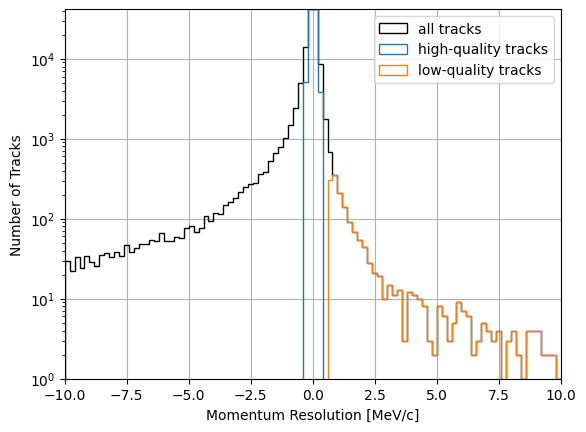

In [9]:
min_mom_res=-10
max_mom_res=10
n_mom_res_bins=100

fig, ax = plt.subplots(1, 1)
bins, counts, patches = ax.hist(mom_res, bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', color='black', label='all tracks')
bins, counts, patches = ax.hist(mom_res[high_qual], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', label='high-quality tracks')
bins, counts, patches = ax.hist(mom_res[low_qual], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', label='low-quality tracks')
ax.legend()
ax.margins(0)
ax.grid(True)
ax.set_xlabel("Momentum Resolution [MeV/c]")
ax.set_ylabel("Number of Tracks")

Here we plot all the training features. Note that we have used ```density=True``` so each histogram is normalized to unit area

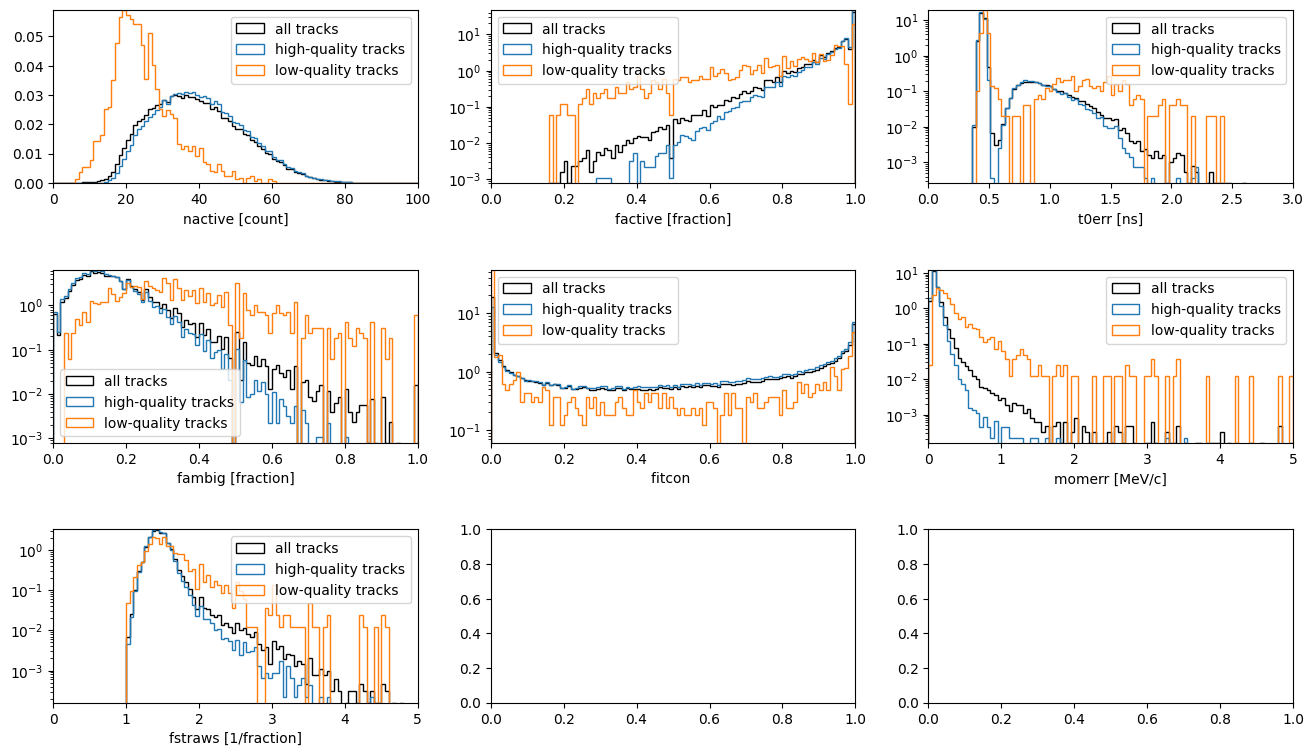

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(16,9))
fig.subplots_adjust(hspace=.5)
x_mins=[0, 0, 0, 0, 0, 0, 0]
x_maxs=[100, 1, 3, 1, 1, 5, 5]
log_ys=[False, True, True, True, True, True, True]
units=['[count]', '[fraction]', '[ns]', '[fraction]', '', '[MeV/c]', '[1/fraction]']
for i_var in range(0, n_input_vars):
    bins, counts, patches = axs.flatten()[i_var].hist(input_dataset[:,i_var], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', color='black', log=log_ys[i_var], label='all tracks', density=True)
    bins, counts, patches = axs.flatten()[i_var].hist(input_dataset[:,i_var][high_qual], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', log=log_ys[i_var], label='high-quality tracks', density=True)
    bins, counts, patches = axs.flatten()[i_var].hist(input_dataset[:,i_var][low_qual], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', log=log_ys[i_var], label='low-quality tracks', density=True)
    axs.flatten()[i_var].set_xlabel(input_var_names[i_var]+" "+units[i_var])
    axs.flatten()[i_var].margins(0)
    axs.flatten()[i_var].legend()

Now we balance the inputs since we don't have that many low-quality tracks to train on

In [11]:
# In this cell x_ variables are features, and y_ are the output results
min_len = min(len(input_dataset[high_qual]), len(input_dataset[low_qual]))

x_high_qual_dataset = input_dataset[high_qual][:min_len]
x_low_qual_dataset = input_dataset[low_qual][:min_len]

x_balanced_input = np.concatenate((x_high_qual_dataset, x_low_qual_dataset))
# set 1 to be high quality, and 0 to be low quality
y_balanced_input = np.concatenate((np.ones(x_high_qual_dataset.shape[0]), np.zeros(x_low_qual_dataset.shape[0])))

# split the dataset into train and test samples
x_train, x_test, y_train, y_test = train_test_split(x_balanced_input, y_balanced_input, test_size=0.5, random_state=42)
# further split the test sample, into testing and validation samples
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
print("N train = "+str(len(x_train)) + ", N test = "+str(len(x_test)) + ", N valid = "+str(len(x_valid)))

N train = 1658, N test = 829, N valid = 829


Here we plot the features for each of the training, testing, and validation samples. All these plots should look similar

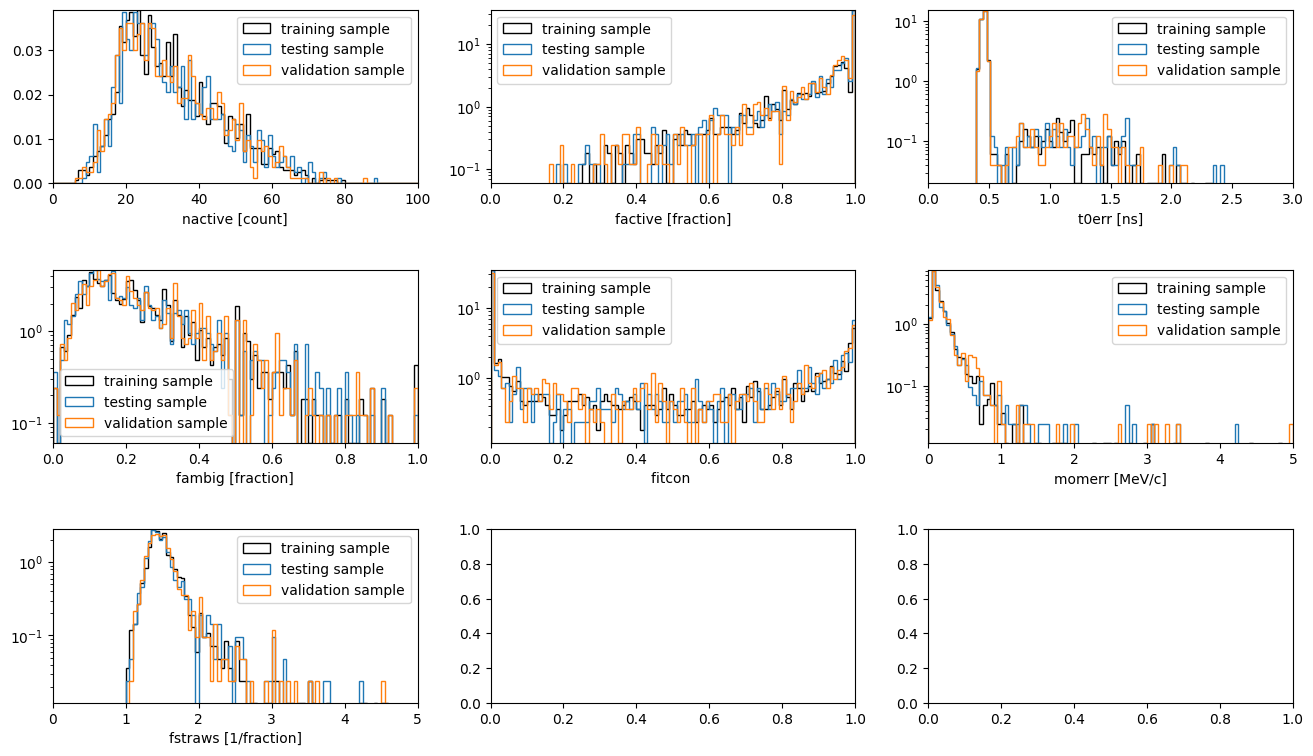

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(16,9))
fig.subplots_adjust(hspace=.5)
for i_var in range(0, n_input_vars):
    bins, counts, patches = axs.flatten()[i_var].hist(x_train[:,i_var], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', color='black', log=log_ys[i_var], label='training sample', density=True)
    bins, counts, patches = axs.flatten()[i_var].hist(x_test[:,i_var], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', log=log_ys[i_var], label='testing sample', density=True)
    bins, counts, patches = axs.flatten()[i_var].hist(x_valid[:,i_var], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', log=log_ys[i_var], label='validation sample', density=True)
    axs.flatten()[i_var].set_xlabel(input_var_names[i_var]+" "+units[i_var])
    axs.flatten()[i_var].margins(0)
    axs.flatten()[i_var].legend()

Here we now build the model and do the training. Here we are copying what was done in the old TrkQual. Namely:
 - N, N-1 neurons in the hidden layers
 - sigmoid activation functions
 - no dropout layers

In [13]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3) # was 1e-3 (2e-2 is from TMVA)

N=n_input_vars
#N=64
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(n_input_vars, activation='sigmoid', input_shape=(n_input_vars,)))
#model_ce.add(Dropout(0.00005))
model.add(tf.keras.layers.Dense(n_input_vars, activation='sigmoid')) # also 'relu'
#model_ce.add(Dropout(0.00005))
model.add(tf.keras.layers.Dense(n_input_vars-1, activation='sigmoid'))
#model_ce.add(Dropout(0.00005))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                 metrics='accuracy',
                 optimizer=opt)
model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(x_train, y_train,
                          epochs=500,
                          verbose=0,
                          validation_data=(x_valid, y_valid),
                          callbacks=[early_stop])
print("Done!")

2023-09-06 18:25:08.810319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/mu2e.opensciencegrid.org/artexternals/python/v3_9_15/Linux64bit+3.10-2.17/lib:/cvmfs/mu2e.opensciencegrid.org/artexternals/sqlite/v3_40_01_00/Linux64bit+3.10-2.17/lib:/mu2e/app/users/edmonds/TrkAnaDev/build/sl7-prof-e20-p047/TrkAna/lib:/mu2e/app/users/edmonds/TrkAnaDev/build/sl7-prof-e20-p047/REve/lib:/mu2e/app/users/edmonds/TrkAnaDev/build/sl7-prof-e20-p047/Production/lib:/mu2e/app/users/edmonds/TrkAnaDev/build/sl7-prof-e20-p047/Offline/lib:/cvmfs/mu2e-development.opensciencegrid.org/museCIBuild/main/26c9f5bf/build/sl7-prof-e20-p047/Production/lib:/cvmfs/mu2e-development.opensciencegrid.org/museCIBuild/main/26c9f5bf/build/sl7-prof-e20-p047/Offline/lib:/cvmfs/mu2e.opensciencegrid.org/artexternals/gmp/v6_2_1/Linux64bit+3.10-2.17/lib:/cvmfs/mu2e.o

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 56        
                                                                 
 dense_1 (Dense)             (None, 7)                 56        
                                                                 
 dense_2 (Dense)             (None, 6)                 48        
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 167
Trainable params: 167
Non-trainable params: 0
_________________________________________________________________
Done!


Now get the predicted values for the input dataset (ideally, this would be a separate dataset)

In [14]:
output_trkqual = model.predict(input_dataset)
trkqual = np.transpose(output_trkqual)[0]

3951/3951 [==============================] - 4s 958us/step


Now we save the model

In [15]:
print(len(input_dataset))
print(len(trkqual))

126413
126413


In [16]:
model.save('model/'+output_modelname)

### Some Validation Plots

Here is the loss as a function of epoch for the training and validation datasets

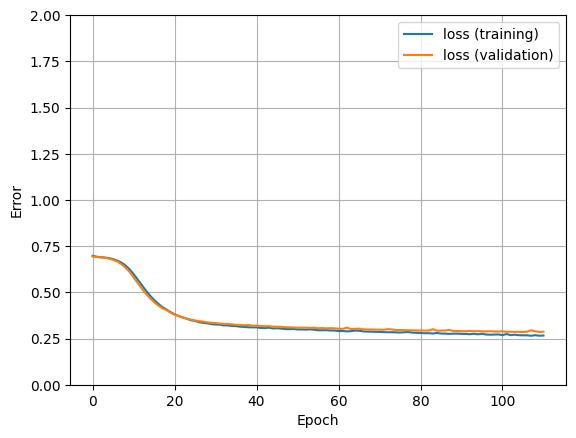

In [17]:
plot_loss(history)

Here we get the ROC curve, as well as the cut value that rejects 99% of low-quality tracks. (For a real analysis, we would find a different optimization procedure)

2935/2935 [==============================] - 3s 1ms/step
[9.39139605e-01 5.45191526e-01 9.94254172e-01 ... 2.02080747e-03
 5.12751518e-04 1.83917102e-04]
A trkqual cut of 0.9 has a low-quality track rejection of 99.0% with a high-quality track efficiency of 57.9%
An old trkqual cut of 0.85 has a low-quality track rejection of 99.0% with a high-quality track efficiency of 59.8%


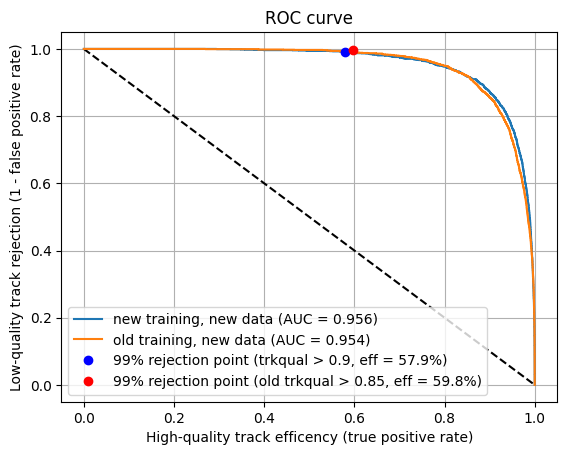

In [18]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(x_balanced_input).ravel()
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_balanced_input, y_pred_keras, pos_label=1)
y_full_input_dataset = np.concatenate((np.ones(input_dataset[high_qual].shape[0]), np.zeros(input_dataset[low_qual].shape[0])))
x_full_input_dataset = np.concatenate((input_dataset[high_qual], input_dataset[low_qual]))
y_full_pred_keras = model.predict(x_full_input_dataset).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_full_input_dataset, y_full_pred_keras, pos_label=1)
y_full_old_trkqual = np.concatenate((old_trkqual[high_qual], old_trkqual[low_qual]))
print(y_full_old_trkqual)
fpr_old, tpr_old, thresholds_old = roc_curve(y_full_input_dataset, y_full_old_trkqual, pos_label=1)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
auc_old = auc(fpr_old, tpr_old)

cut_val_index=0
for i_point in range(0, len(fpr_keras)):
    if 1-fpr_keras[i_point]<0.99:
        cut_val_index=i_point-1
        break

old_cut_val_index=0
for i_point in range(0, len(fpr_old)):
    if 1-fpr_old[i_point]<0.99:
        old_cut_val_index=i_point-1
        break
        
trkqual_cut=(round(thresholds_keras[cut_val_index], 2))
bkg_rej = 1-fpr_keras[cut_val_index]
sig_eff = tpr_keras[cut_val_index]
print("A trkqual cut of "+str(trkqual_cut)
      +" has a low-quality track rejection of "+str(round(bkg_rej*100,1))
      +"% with a high-quality track efficiency of "+str(round(sig_eff*100,1))+"%")

old_trkqual_cut=(round(thresholds_old[old_cut_val_index], 2))
old_bkg_rej = 1-fpr_old[old_cut_val_index]
old_sig_eff = tpr_old[old_cut_val_index]
print("An old trkqual cut of "+str(old_trkqual_cut)
      +" has a low-quality track rejection of "+str(round(old_bkg_rej*100,1))
      +"% with a high-quality track efficiency of "+str(round(old_sig_eff*100,1))+"%")

plt.figure(1)
plt.plot([0, 1], [1, 0], 'k--')
plt.plot(tpr_keras, 1-fpr_keras, label='new training, new data (AUC = {:.3f})'.format(auc_keras))
plt.plot(tpr_old, 1-fpr_old, label='old training, new data (AUC = {:.3f})'.format(auc_old))
plt.xlabel('High-quality track efficency (true positive rate)')
plt.ylabel('Low-quality track rejection (1 - false positive rate)')
plt.plot(tpr_keras[cut_val_index], 1-fpr_keras[cut_val_index], 'bo', label='99% rejection point (trkqual > '+str(trkqual_cut)+', eff = '+str(round(sig_eff*100,1))+'%)')
plt.plot(tpr_old[old_cut_val_index], 1-fpr_keras[old_cut_val_index], 'ro', label='99% rejection point (old trkqual > '+str(old_trkqual_cut)+', eff = '+str(round(old_sig_eff*100,1))+'%)')
plt.title('ROC curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## Results

Now we make the main plot: the momentum resolution with the trkqual cut we found for 99% low-quality track rejection

Text(0, 0.5, 'Number of Tracks')

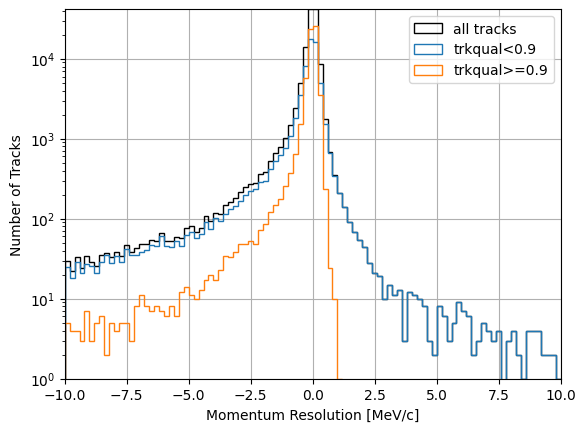

In [19]:
fig, ax = plt.subplots(1,1)
_, _, _, = ax.hist(mom_res, bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', color='black', label='all tracks')
_, _, _, = ax.hist(mom_res[trkqual<trkqual_cut], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', label='trkqual<'+str(trkqual_cut))
_, _, _, = ax.hist(mom_res[trkqual>=trkqual_cut], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', label='trkqual>='+str(trkqual_cut))
ax.legend()
ax.margins(0)
ax.grid(True)
ax.set_xlabel("Momentum Resolution [MeV/c]")
ax.set_ylabel("Number of Tracks")

Text(0, 0.5, 'Number of Tracks')

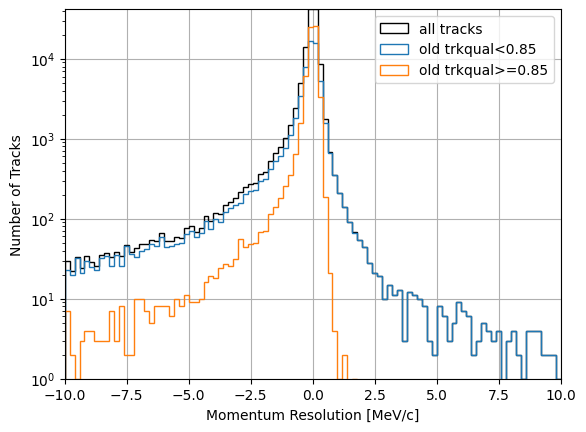

In [20]:
fig, ax = plt.subplots(1,1)
_, _, _, = ax.hist(mom_res, bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', color='black', label='all tracks')
_, _, _, = ax.hist(mom_res[old_trkqual<old_trkqual_cut], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', label='old trkqual<'+str(old_trkqual_cut))
_, _, _, = ax.hist(mom_res[old_trkqual>=old_trkqual_cut], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', label='old trkqual>='+str(old_trkqual_cut))
ax.legend()
ax.margins(0)
ax.grid(True)
ax.set_xlabel("Momentum Resolution [MeV/c]")
ax.set_ylabel("Number of Tracks")

Text(0, 0.5, 'Number of Tracks')

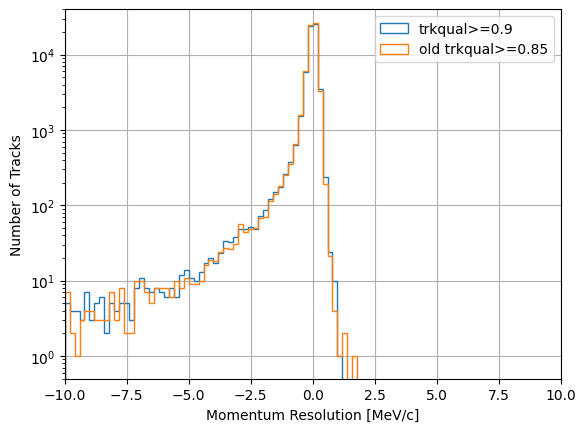

In [21]:
fig, ax = plt.subplots(1,1)
_, _, _, = ax.hist(mom_res[trkqual>=trkqual_cut], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', label='trkqual>='+str(trkqual_cut))
_, _, _, = ax.hist(mom_res[old_trkqual>=old_trkqual_cut], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', label='old trkqual>='+str(old_trkqual_cut))
ax.legend()
ax.margins(0)
ax.grid(True)
ax.set_ylim(0.5, 4e4)
ax.set_xlabel("Momentum Resolution [MeV/c]")
ax.set_ylabel("Number of Tracks")

In [20]:
import keras
print(keras.__version__)

2.13.1
